In [1]:
import pandas as pd
df = pd.read_csv(r'craigslistJobTitles.csv',encoding = "ISO-8859-1")
df.head()

,category,jobtitle
0,education,After School Supervisor
1,education,"*****TUTORS NEEDED - FOR ALL SUBJECTS, ALL AGE..."
2,education,Bay Area Family Recruiter
3,education,Adult Day Programs/Community Access/Job Coaches
4,education,General Counselor - Non Tenure track


In [5]:
from io import StringIO

df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

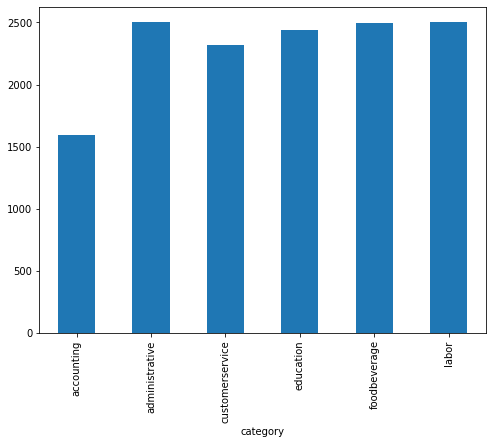

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').jobtitle.count().plot.bar(ylim=0)
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
len(df)

13845

In [9]:
features = tfidf.fit_transform(df.jobtitle).toarray()
labels = df.category_id
features.shape

(13845, 3212)

In [11]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'accounting':
  . Most correlated unigrams:
. accounting
. accountant
  . Most correlated bigrams:
. staff accountant
. senior accountant
# 'administrative':
  . Most correlated unigrams:
. assistant
. administrative
  . Most correlated bigrams:
. executive assistant
. administrative assistant
# 'customerservice':
  . Most correlated unigrams:
. service
. customer
  . Most correlated bigrams:
. service representative
. customer service
# 'education':
  . Most correlated unigrams:
. preschool
. teacher
  . Most correlated bigrams:
. tutors needed
. preschool teacher
# 'foodbeverage':
  . Most correlated unigrams:
. restaurant
. cook
  . Most correlated bigrams:
. line cooks
. line cook
# 'labor':
  . Most correlated unigrams:
. 595
. uber
  . Most correlated bigrams:
. make 595
. 595 week


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

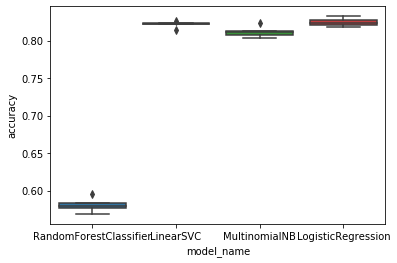

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
#sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=5, linewidth=1)
plt.show()

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.822031
LogisticRegression        0.824415
MultinomialNB             0.811991
RandomForestClassifier    0.580714
Name: accuracy, dtype: float64

In [19]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.583394
1,RandomForestClassifier,1,0.595307
2,RandomForestClassifier,2,0.568953
3,RandomForestClassifier,3,0.576951
4,RandomForestClassifier,4,0.578966
5,LinearSVC,0,0.822744
6,LinearSVC,1,0.814801
7,LinearSVC,2,0.822744
8,LinearSVC,3,0.823338
9,LinearSVC,4,0.826527


In [39]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/tljh/user/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


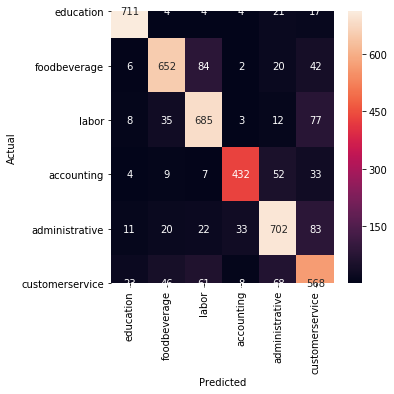

In [40]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [2]:
import xgboost
model.fit(features, labels)
N = 2


for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

ModuleNotFoundError: No module named 'xgboost'